# Libraries

In [2]:
# For Clean Tensorflow Verbosity
import os
from silence_tensorflow import silence_tensorflow

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
silence_tensorflow()

# Loading Data
from pandas import read_csv
from pandas import DataFrame

# Manipulation
from numpy import float32
from numpy import reshape
from numpy import hstack
from numpy import sort

# Plotting
from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from seaborn import barplot

# Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

from tensorflow import saved_model
from tensorflow import tensordot
from tensorflow import nn

from keras.callbacks import Callback # type: ignore
from keras.callbacks import EarlyStopping # type: ignore
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras import losses
from keras import layers
from keras import Model

import numpy as np
import random

# 1. Data Understanding

## 1.1. Downloading Data

In [4]:
# Make folder to store dataset
os.makedirs('./data', exist_ok=True)

# Downloading dataset from kaggle
!kaggle datasets download CooperUnion/anime-recommendations-database -p data/

# Extract Dataset to data folder
!unzip data/anime-recommendations-database.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
100%|█████████████████████████████████████▉| 25.0M/25.0M [00:14<00:00, 1.66MB/s]
100%|██████████████████████████████████████| 25.0M/25.0M [00:14<00:00, 1.81MB/s]
Archive:  data/anime-recommendations-database.zip
  inflating: data/anime.csv          
  inflating: data/rating.csv         


## 1.2. Data Loading

In [3]:
anime_data = read_csv('./data/anime.csv')
rating_data = read_csv('./data/rating.csv')

anime_data.shape
print("Data Anime  =>", anime_data.shape[0], "baris dan", anime_data.shape[1], "kolom")
print("Data Rating =>", rating_data.shape[0], "baris dan", rating_data.shape[1], "kolom")

Data Anime  => 12294 baris dan 7 kolom
Data Rating => 7813737 baris dan 3 kolom


## 1.3. Exploratory Data Analysis (EDA)

### anime.csv

menampilkan 5 data teratas dari file anime.csv

In [4]:
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


melihat struktur data dari setiap kolom

In [5]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


menampilkan statistik deskriptif dari rating pada anime

In [6]:
anime_data['rating'].describe()

count    12064.000000
mean         6.473902
std          1.026746
min          1.670000
25%          5.880000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

### rating.csv

Melihat sample data rating

In [7]:
rating_data

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Menampilkan informasi statistik deskriptif

In [8]:
rating_data['rating'].describe()

count    7.813737e+06
mean     6.144030e+00
std      3.727800e+00
min     -1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

#### Distribusi Rating

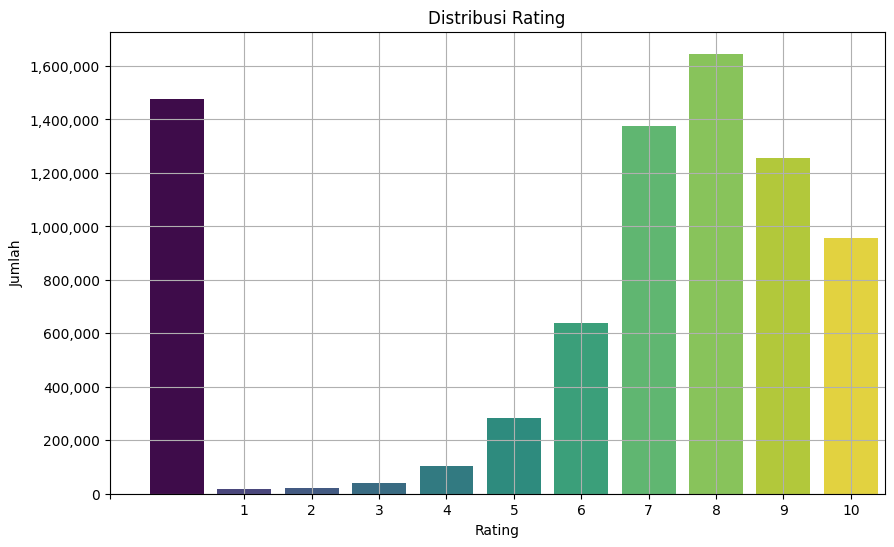

In [37]:
rating_count = rating_data['rating'].value_counts(sort=False)

def y_format(x, pos): return '{:,.0f}'.format(x)
plt.figure(figsize=(10, 6))
barplot(x=rating_count.index, y=rating_count.values, palette='viridis', hue=rating_count.index, legend=False)
plt.title('Distribusi Rating')
plt.xticks(rating_count.index)
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format))
plt.grid(True)
plt.show()

Berdasarkan bar plotting di atas dapat dilihat jumlahh anime yang belum diberi rating berada di atas 1400000. Sedangkan jumlah anime terbanyak terdapat pada rating 8 yaitu lebih dari 1600000.

#### Distribusi Jumlah Rating ynag diberikan User

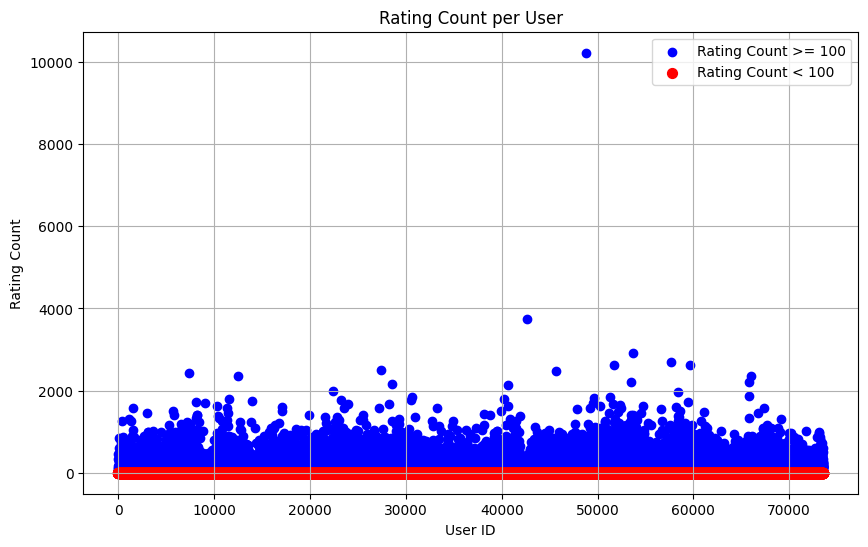

In [10]:
user_rating_count = rating_data.groupby('user_id')['rating'].count().reset_index().rename(columns = {'rating': 'rating_count'})
hightlight_user = user_rating_count['rating_count'] < 100

plt.figure(figsize=(10, 6))
plt.scatter(user_rating_count['user_id'], user_rating_count['rating_count'], color='blue', label="Rating Count >= 100")
plt.scatter(hightlight_user.index, hightlight_user.values, color='red', s=50,  label="Rating Count < 100")
plt.xlabel("User ID")
plt.ylabel("Rating Count")
plt.title("Rating Count per User")
plt.grid()
plt.legend()
plt.show()

Terdapat banyak user yang memberi rating kurang dari 100. Ini membuat mereka menjadi user pasif dan dapat menyebabkan bias pada model.

Menghitung jumlah rating yang kurang dari 100

In [11]:
hightlight_user.value_counts()

rating_count
True     48656
False    24859
Name: count, dtype: int64

#### Distribusi Jumlah Rating yang didapatkan Anime

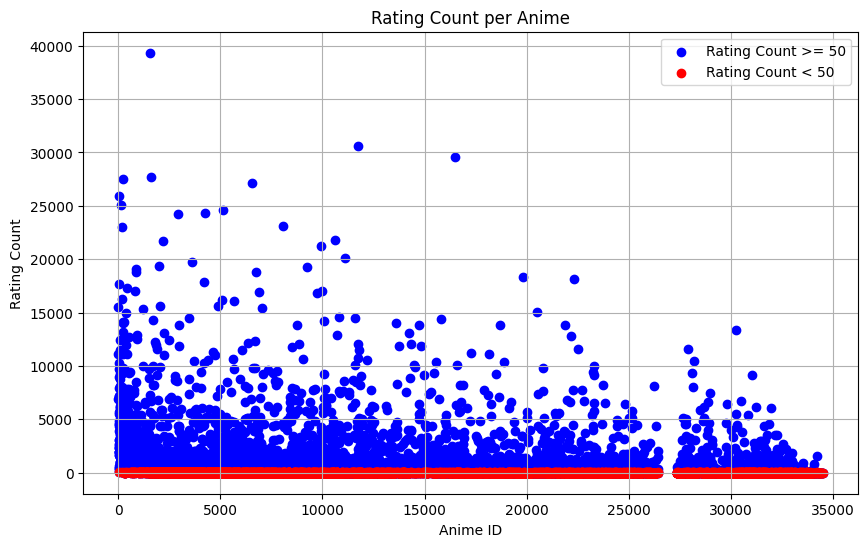

In [12]:
anime_count_rating = rating_data['anime_id'].value_counts()
hightlight_anime = anime_count_rating[anime_count_rating.values < 50]

plt.figure(figsize=(10, 6))
plt.scatter(anime_count_rating.index, anime_count_rating.values, color='blue', label="Rating Count >= 50")
plt.scatter(hightlight_anime.index, hightlight_anime.values, color='red',  label="Rating Count < 50")
plt.xlabel("Anime ID")
plt.ylabel("Rating Count")
plt.title("Rating Count per Anime")
plt.grid()
plt.legend()
plt.show()

Terlihat jumlah anime dengan jumlah rating kurang dari 50 terdapat hampir sepanjang sumbu x yang merupakan anime_id. Anime ini dapat menyebabkan bias pada model karena masih sedikitnya user yang memberi rating

Menghitung jumlah rating yang kurang dari 50

In [13]:
hightlight_anime.shape

(5549,)

Menyalin dataset ke dalam variabel baru

In [14]:
anime_df = anime_data.copy()
rating_df = rating_data.copy()

# 2. Content-Based Filtering

## 2.1. Data Preparation

### 2.1.1. Missing Value

In [17]:
print(anime_df.isnull().sum())
anime_df[anime_df.isnull().any(axis=1)].sample(3)

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


,anime_id,name,genre,type,episodes,rating,members
11036,33788,Marginal#4: Kiss kara Tsukuru Big Bang,"Music, Shoujo",TV,Unknown,NaN,1766
11072,32836,Senki Zesshou Symphogear 4th Season,"Action, Music, Sci-Fi",TV,Unknown,NaN,1880
11090,32596,The Snack World (TV),"Adventure, Comedy, Fantasy, Kids",TV,Unknown,NaN,107


Terdapat 277 data yang memilik missing value. Karena jumlahnya sedikit maka data dengan missing value akan dihapus

In [18]:
anime_df = anime_df.dropna()           # Drop missing value
print(anime_df.isnull().sum())         # Periksa kembali missing value
print("Sekarang dataset anime sudah bersih dari missing value dan jumlah data berkurang menjadi", anime_df.shape[0])

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64
Sekarang dataset anime sudah bersih dari missing value dan jumlah data berkurang menjadi 12017


### 2.1.2. Feature Encoding

In [19]:
list_genres = sort(anime_df['genre'].str.split(', ').explode('genre').unique())
num_genre = len(list_genres)
print("Terdapat [", num_genre, "] genre anime yang berbeda")
print(list_genres)

Terdapat [ 43 ] genre anime yang berbeda
['Action' 'Adventure' 'Cars' 'Comedy' 'Dementia' 'Demons' 'Drama' 'Ecchi'
 'Fantasy' 'Game' 'Harem' 'Hentai' 'Historical' 'Horror' 'Josei' 'Kids'
 'Magic' 'Martial Arts' 'Mecha' 'Military' 'Music' 'Mystery' 'Parody'
 'Police' 'Psychological' 'Romance' 'Samurai' 'School' 'Sci-Fi' 'Seinen'
 'Shoujo' 'Shoujo Ai' 'Shounen' 'Shounen Ai' 'Slice of Life' 'Space'
 'Sports' 'Super Power' 'Supernatural' 'Thriller' 'Vampire' 'Yaoi' 'Yuri']


Membuat kamus genre yang berisikan index dan index yang telah di encoding

In [20]:
genre_encode_dict = {genre : i for i, genre in enumerate(list_genres)}
genre_decode_dict = {i : genre for i, genre in enumerate(list_genres)}

Membuat fungsi encoder genre

In [21]:
def genre_encoding(data):
    return ' '.join([str(genre_encode_dict[genre]) for genre in data.split(', ')])

Membuat fungsi decoder genre

In [22]:
def genre_decoding(data):
    return ', '.join(genre_decode_dict[int(genre)] for genre in data.split())

Menguji fungsi encoder dan decoder genre

In [24]:
test_genre = anime_df['genre'].sample(1).values[0]
print("Genre         : ", test_genre)

test_genre_encoded = genre_encoding(test_genre)
print("Genre Encoded : ", test_genre_encoded)

test_genre_decoded = genre_decoding(test_genre_encoded)
print("Genre Decoded : ", test_genre_decoded)

Genre         :  Comedy, Drama, Josei, Romance
Genre Encoded :  3 6 14 25
Genre Decoded :  Comedy, Drama, Josei, Romance


Menerapkan fungsi encoder ke anime dataframe

In [42]:
anime_df['genre'] = anime_df['genre'].apply(genre_encoding)
anime_df.sample(5)

,anime_id,name,genre,type,episodes,rating,members
3709,10502,Tansu Warashi.,3 34 38,Movie,1,6.91,4028
3561,7367,Naruto: The Cross Roads,0 1 3 32,Special,1,6.95,22131
9484,9856,Manga Nihon Emaki,12,TV,46,6.17,122
11960,3921,Kamyla,11 23,OVA,3,5.83,1091
10628,23537,Two Down Full Base,15 36,Special,1,6.38,57


### 2.1.3. TF-IDF

Membuat object tfidf vectorizer

In [26]:
# Menambahkan [token_pattern=r'\b\w+\b'] agar TFIDF tidak melewati karakter 1 digit
tfidf = TfidfVectorizer(token_pattern=r'\b\w+\b')
tfidf.fit(anime_df['genre'])
tfidf.get_feature_names_out()

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '4', '40', '41', '42', '5', '6', '7', '8', '9'], dtype=object)

Menerapkan object tfidf vectorizer ke anime dataframe

In [27]:
matrix = tfidf.fit_transform(anime_df['genre'])
matrix.shape

(12017, 43)

Melihat sample matrix tfidf

In [28]:
DataFrame(matrix.todense(), index=anime_df['name'], columns=[genre_decode_dict[int(x)] for x in tfidf.get_feature_names_out()]).sample(10, axis=1).sample(10, axis=0)

,Super Power,Game,Horror,Seinen,Shoujo,Adventure,Space,Josei,Shounen Ai,Historical
name,,,,,,,,,,
Ninja-tai Gatchaman ZIP!,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Kakutou Bijin Wulong: Rebirth,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Futari no Joe,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Penguin&#039;s Memory: Shiawase Monogatari,0.0,0.0,0.000000,0.621717,0.0,0.0,0.000000,0.0,0.0,0.0
Tsuzuki wo Kangaeru Monogatari,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Mobile Suit Gundam Unicorn RE:0096,0.0,0.0,0.000000,0.000000,0.0,0.0,0.521114,0.0,0.0,0.0
Yell,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Kyoto Animation: Ajisai-hen,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
Tokyo Ghoul: &quot;Pinto&quot;,0.0,0.0,0.477662,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


## 2.2. Model Development

### 2.2.1. Cosine Similarity

In [29]:
similarity = cosine_similarity(matrix)
print(similarity.shape)

(12017, 12017)


Menyimpan matrix cosine similarity dalam bentuk dataframe

In [33]:
similarity_df = DataFrame(similarity, index=anime_df['name'], columns=anime_df['name'])
similarity_df.sample(3, axis=1).sample(3, axis=0)   # Print sample of similarity matrix

name,Go! Samurai,Tono to Issho: Ippunkan Gekijou,Kuroko no Basket: Baka ja Katenai no yo!
name,,,
"Ore, Twintail ni Narimasu.",0.149994,0.079934,0.544031
Gakkougurashi!,0.000000,0.000000,0.188426
Geori-eui Mubeopja,0.189506,0.000000,0.000000


In [21]:
# similarity_df.merge(anime_df, on='name')

### 2.2.2. Fungsi Rekomendasi

In [40]:
def content_recommendation(title, similarity=similarity_df, dataframe=anime_df, top_n=10):
    try:
        # Get the similarity scores for the given anime
        similarity_score = similarity.loc[:, title]

        # Sort the scores in descending order and get the top k indices
        # We add 1 to k to exclude the anime itself from the recommendations
        top_n_animes = similarity_score.sort_values(ascending=False)[0:top_n+1].drop(title)
        top_n_animes = np.vstack((top_n_animes.index, top_n_animes.values)).T

        recommendation = DataFrame(top_n_animes, columns=['name', 'similarity_score']).merge(dataframe[['name', 'genre']])
        recommendation = recommendation[['name', 'genre', 'similarity_score']]
        recommendation['genre'] = recommendation['genre'].apply(genre_decoding)

        return recommendation
    
    except KeyError:
        return "Anime Tidak Ditemukan pada Database"

### 2.2.3. Simulasi Sistem Rekomendasi

In [54]:
# Memilih satu anime secara acak
test_title = random.choice(anime_df['name'])
test_genre = anime_df.loc[anime_df['name'] == test_title, 'genre'].values[0]

# Mendapatkan rekomendasi
recommendations = content_recommendation(title=test_title)

# Menampilkan rekomendasi
print("Judul :", test_title)
print("Genre :", genre_decoding(test_genre))
print("Rekomendasi:")
recommendations

Judul : UFO Princess Valkyrie: Recap
Genre : Comedy, Romance, Sci-Fi
Rekomendasi:


,name,genre,similarity_score
0,Hoshi Neko Fullhouse,"Comedy, Romance, Sci-Fi",1.0
1,Narue no Sekai,"Comedy, Romance, Sci-Fi",1.0
2,Misute♡naide Daisy,"Comedy, Romance, Sci-Fi",1.0
3,UFO Princess Valkyrie: Special,"Comedy, Romance, Sci-Fi",1.0
4,UFO Princess Valkyrie 2: Juunigatsu no Yasoukyoku,"Comedy, Romance, Sci-Fi",1.0
5,Blue Seed 1.5,"Comedy, Romance, Sci-Fi",1.0
6,Onegai☆Teacher: Reminiscence Disc,"Comedy, Romance, Sci-Fi",1.0
7,UFO Princess Valkyrie 4: Toki to Yume to Ginga...,"Comedy, Romance, Sci-Fi",1.0
8,DNA²,"Comedy, Romance, Sci-Fi",1.0
9,Soul Link Picture Drama,"Romance, Sci-Fi",0.904857


## 2.3. Evaluation

Membuat fungsi evaluasi model berdasarkan similarity score

In [55]:
def content_model_evaluation(recommendations):
    sum_score = 0
    for score in recommendations.similarity_score: sum_score += score
    return sum_score / len(recommendations)

Melakukan evaluasi model

In [56]:
print("Precision dari Model Content Based Filtering : {:.2f}%".format(content_model_evaluation(recommendations) * 100))

Precision dari Model Content Based Filtering : 99.05%


# 3. Collaborative Filtering

## 3.1. Data Preparation

### 3.1.1. Missing Value

In [57]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

Tidak terdapat missing value pada dataset rating.csv

### 3.1.2. Unrated Anime

In [58]:
print("Jumlah data rating sebelum unrated anime dihapus:", rating_df.shape[0])
rating_df = rating_df.loc[rating_df['rating'] != -1]
print("Jumlah data rating setelah unrated anime dihapus:", rating_df.shape[0])

Jumlah data rating sebelum unrated anime dihapus: 7813737
Jumlah data rating setelah unrated anime dihapus: 6337241


### 3.1.3. Bias Data

#### 3.1.2.1. Feature User ID

In [59]:
print("Jumlah user sebelum bias removal:", len(rating_df['user_id'].unique()))

user_rating_count = rating_df['user_id'].value_counts()
user_valid = user_rating_count[user_rating_count >= 100]
rating_df = rating_df.loc[rating_df['user_id'].isin(user_valid.index)]

print("Jumlah user setelah bias removal:", len(rating_df['user_id'].unique()))

Jumlah user sebelum bias removal: 69600
Jumlah user setelah bias removal: 19949


#### 3.1.2.2. Feature Anime ID

In [60]:
print("Jumlah anime sebelum bias removal:", rating_df['anime_id'].nunique())

anime_rating_count = rating_df['anime_id'].value_counts()
anime_valid = anime_rating_count[anime_rating_count >= 100]
rating_df = rating_df.loc[rating_df['anime_id'].isin(anime_valid.index)]

print("Jumlah anime setelah bias removal:", rating_df['anime_id'].nunique())

Jumlah anime sebelum bias removal: 9890
Jumlah anime setelah bias removal: 3981


### 3.1.4. Feature Encoding

#### User ID Encoding

Membuat kamus user_id encoded dan decoded

In [61]:
userID = rating_df['user_id'].unique().tolist()
userID_encoded_dict = {x : i for i, x in enumerate(userID)}
userID_decoded_dict = {i : x for i, x in enumerate(userID)}

Melakukan encoding ke user_id pada rating.csv

In [62]:
rating_df['user_id_encoded'] = rating_df['user_id'].map(userID_encoded_dict)

#### Anime ID encoding

In [63]:
animeID = rating_df['anime_id'].unique().tolist()
animeID_encoded_dict = {x : i for i, x in enumerate(animeID)}
animeID_decoded_dict = {i : x for i, x in enumerate(animeID)}

Melakukan encoding ke anime_id pada rating.csv

In [64]:
rating_df['anime_id_encoded'] = rating_df['anime_id'].map(animeID_encoded_dict)

In [65]:
rating_df

,user_id,anime_id,rating,user_id_encoded,anime_id_encoded
302,5,6,8,0,0
303,5,15,6,0,1
304,5,17,6,0,2
305,5,18,6,0,3
306,5,20,6,0,4
...,...,...,...,...,...
7813730,73515,13659,8,19948,275
7813731,73515,14345,7,19948,772
7813732,73515,16512,7,19948,546
7813733,73515,17187,9,19948,1548


### 3.1.5. Convert Rating Values to Float

In [66]:
rating_df['rating'] = rating_df.loc[:, 'rating'].values.astype(float32)

min_rating = min(rating_df['rating'])
print("Rating Terendah:", min_rating)

max_rating = max(rating_df['rating'])
print("Rating Tertinggi:", max_rating)

Rating Terendah: 1.0
Rating Tertinggi: 10.0


### 3.1.6. Seleksi Fitur

Mengacak data pada dataframe rating

In [67]:
rating_df = rating_df.sample(frac=1, random_state=22)
rating_df

,user_id,anime_id,rating,user_id_encoded,anime_id_encoded
2571620,24349,1517,3.0,6657,3271
1839209,17821,30240,10.0,4729,954
5996453,56287,31680,10.0,15249,1309
6470016,59789,1051,7.0,16441,1575
4919079,47123,19251,8.0,12639,1705
...,...,...,...,...,...
5379011,50888,228,8.0,13784,788
5539469,52097,490,6.0,14157,2639
4495194,42635,388,6.0,11571,2253
292430,3029,10087,8.0,752,850


In [68]:
x = rating_df[['user_id_encoded', 'anime_id_encoded']].values
y = rating_df['rating']

print("Dimensi Fitur :", x.shape)
print("Dimensi Label :", y.shape)

Dimensi Fitur : (4622979, 2)
Dimensi Label : (4622979,)


### 3.1.7. Normalisasi

In [69]:
scaler = MinMaxScaler()
scaler.fit(reshape(y, (-1, 1)))
y = scaler.fit_transform(reshape(y, (-1, 1)))

### 3.1.8. Data Splitting

In [70]:
train_indicies = int(0.8 * rating_df.shape[0])
x_train, x_valid, y_train, y_valid = (x[:train_indicies], x[train_indicies:], y[:train_indicies], y[train_indicies:])

print("Dimensi Fitur Latih    :", x_train.shape)
print("Dimensi Label Latih    :", y_train.shape)
print("Dimensi Fitur Validasi :", x_valid.shape)
print("Dimensi Label Validasi :", y_valid.shape)

Dimensi Fitur Latih    : (3698383, 2)
Dimensi Label Latih    : (3698383, 1)
Dimensi Fitur Validasi : (924596, 2)
Dimensi Label Validasi : (924596, 1)


## 3.2. Model Development

### 3.2.1. Getting Len of User & Anime

In [71]:
num_user = len(userID_encoded_dict)
print("Jumlah User  :", num_user)

num_anime = len(animeID_encoded_dict)
print("Jumlah Anime :", num_anime)


Jumlah User  : 19949
Jumlah Anime : 3981


### 3.2.2. Define Model

In [72]:
class RecommenderNet(Model):
    def __init__(self, num_user, num_anime, embedding_size, *args, **kwargs):
        super(RecommenderNet, self).__init__(*args, **kwargs)
        self.num_user = num_user
        self.num_anime = num_anime
        self.embedding_size = embedding_size

        # User Embedding Layer
        self.user_embedding = layers.Embedding(
            num_user,
            embedding_size,
            embeddings_initializer= 'he_normal',
            embeddings_regularizer= regularizers.l2(1e-6)
        )

        # User Bias Embedding Layer
        self.user_bias = layers.Embedding(num_user, 1)

        # Anime Embedding Layer
        self.anime_embedding = layers.Embedding(
            num_anime,
            embedding_size,
            embeddings_initializer= 'he_normal',
            embeddings_regularizer= regularizers.l2(1e-6)
        )

        # Anime Bias Embedding Layer
        self.anime_bias = layers.Embedding(num_anime, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 0])
        anime_bias = self.anime_bias(inputs[:, 0])

        dot_matrix = tensordot(user_vector, anime_vector, 2)

        x = dot_matrix + user_bias + anime_bias

        # Activation Layer
        return nn.sigmoid(x)

### 3.2.3. Callback

In [73]:
myCallback = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=5, restore_best_weights=True)

### 3.2.4. Compile Model

In [74]:
model = RecommenderNet(num_user, num_anime, 50)

model.compile(
    loss = losses.MeanSquaredError(),
    optimizer = optimizers.Adam(learning_rate=0.0001),
    metrics = [metrics.RootMeanSquaredError]
)

### 3.2.5. Train Model

In [78]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 128,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks = myCallback
)

Epoch 1/100
28894/28894 ━━━━━━━━━━━━━━━━━━━━ 103s 4ms/step - loss: 0.0265 - root_mean_squared_error: 0.1621 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1586
Epoch 2/100
28894/28894 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - loss: 0.0249 - root_mean_squared_error: 0.1572 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1554
Epoch 3/100
28894/28894 ━━━━━━━━━━━━━━━━━━━━ 103s 4ms/step - loss: 0.0240 - root_mean_squared_error: 0.1546 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1540
Epoch 4/100
28894/28894 ━━━━━━━━━━━━━━━━━━━━ 101s 4ms/step - loss: 0.0237 - root_mean_squared_error: 0.1533 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1527
Epoch 5/100
28894/28894 ━━━━━━━━━━━━━━━━━━━━ 105s 4ms/step - loss: 0.0234 - root_mean_squared_error: 0.1523 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1521
Epoch 6/100
28894/28894 ━━━━━━━━━━━━━━━━━━━━ 106s 4ms/step - loss: 0.0232 - root_mean_squared_error: 0.1515 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1514
Epoch 7/10

### 3.2.6. Fungsi Rekomendasi

In [ ]:
def collaborative_recommendation(userID, k=10):
    # Mengambil sample user
    user_id_test = userID

    # Membuat list anime yang telah ditonton user
    user_anime_watched = rating_df[rating_df['user_id'] == user_id_test]

    # Mendapatkan list anime yang belum ditonton user
    # operator ~(bitwise) membalikan nilai boolean
    user_new_anime = anime_df[~anime_df['anime_id'].isin(user_anime_watched.anime_id.values)]['anime_id']
    user_new_anime = list(
        set(user_new_anime).intersection(set(animeID_encoded_dict.keys()))
    )

    # Decode anime_id yang ada dalam list anime yang belum ditonton user
    user_new_anime = [[animeID_encoded_dict.get(x)] for x in user_new_anime]

    # Decode user id
    user_encoder = userID_encoded_dict.get(user_id_test)

    # Membuat array yang memasangkan user_id dan anime_id yang telah di-encode
    anime_array = hstack(
        ([[user_encoder]] * len(user_new_anime), user_new_anime)
    )

    # Melakukan prediksi rating pada anime baru
    ratings = model.predict(anime_array).flatten()

    # mengurutkan dari nilai terkecil dan mengembalikan index
    # [-10:] => mengambil 10 nilai terakhir
    # [::-1] => reverse urutan dalam array
    top_rating_indicies = ratings.argsort()[-k:][::-1]

    # Decode anime_id yang akan di rekomendasikan
    anime_recommendation_ids = [animeID_decoded_dict.get(user_new_anime[x][0]) for x in top_rating_indicies]

    # Mengambil 5 anime terbaik yang telah ditonton user
    top_user_animes = (
        user_anime_watched.sort_values(
            by = 'rating',
            ascending = False
        )
        .head(5)
        .anime_id.values
    )

    top_anime = anime_df[anime_df['anime_id'].isin(top_user_animes)]
    list_old_title = []
    list_old_genre = []
    for row in top_anime.itertuples():
        list_old_title.append(row.name)
        list_old_genre.append(genre_decoding(row.genre))
        # print(row.name, '=>', genre_decoding(row.genre))

    top_anime_df = DataFrame({'Judul Anime': list_old_title, 'Genre': list_old_genre})

    # Cetak List Rekomendasi Anime
    anime_recommendation = anime_df[anime_df['anime_id'].isin(anime_recommendation_ids)]
    list_new_title = []
    list_new_genre = []
    for row in anime_recommendation.itertuples():
        list_new_title.append(row.name)
        list_new_genre.append(genre_decoding(row.genre))
        # print(row.name, '=>', genre_decoding(row.genre))

    recommendations = DataFrame({'Judul Anime': list_new_title, 'Genre': list_new_genre})

    # print("=================================")
    return top_anime_df, recommendations

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### 3.2.7. Simulasi Sistem Rekomendasi Collaborative Filtering

Melakukan prediksi rating dan menyimpan 10 rating teratas dalam variabel recommendations

In [ ]:
top_anime_df, recommendations = collaborative_recommendation(666)

Mencetak 5 anime terbaik yang pernah ditonton oleh user

In [149]:
print("===  Your Best Anime Watched  ===")
top_anime_df

===  Your Best Anime Watched  ===


,Judul Anime,Genre
0,Haikyuu!!,"Comedy, Drama, School, Shounen, Sports"
1,No Game No Life,"Adventure, Comedy, Ecchi, Fantasy, Game, Super..."
2,Digimon Adventure,"Action, Adventure, Comedy, Fantasy, Kids"
3,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P..."
4,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School"


Menampilkan top 10 rekomendasi anime untuk user

In [151]:
print("=== Your Anime Recommendation ===")
recommendations

=== Your Anime Recommendation ===


,Judul Anime,Genre
0,Noblesse: Awakening,"Action, School, Supernatural, Vampire"
1,Nodame Cantabile OVA 2,"Comedy, Josei, Romance"
2,Acchi Kocchi (TV): Place=Princess,"Comedy, Romance, School, Seinen, Slice of Life"
3,One Piece: Romance Dawn,"Action, Comedy, Fantasy, Shounen, Super Power"
4,Uchuu Show e Youkoso,"Adventure, Fantasy, Space"
5,Soukyuu no Fafner: Dead Aggressor - Heaven and...,"Action, Drama, Mecha, Military, Sci-Fi"
6,Mangaka-san to Assistant-san to The Animation ...,"Comedy, Ecchi, Harem, Seinen, Slice of Life"
7,Buddy Complex: Kanketsu-hen - Ano Sora ni Kaer...,"Action, Mecha, Sci-Fi"
8,Bananya,"Comedy, Kids, Slice of Life"
9,Fumiko no Kokuhaku,Comedy


## 3.3. Evaluation

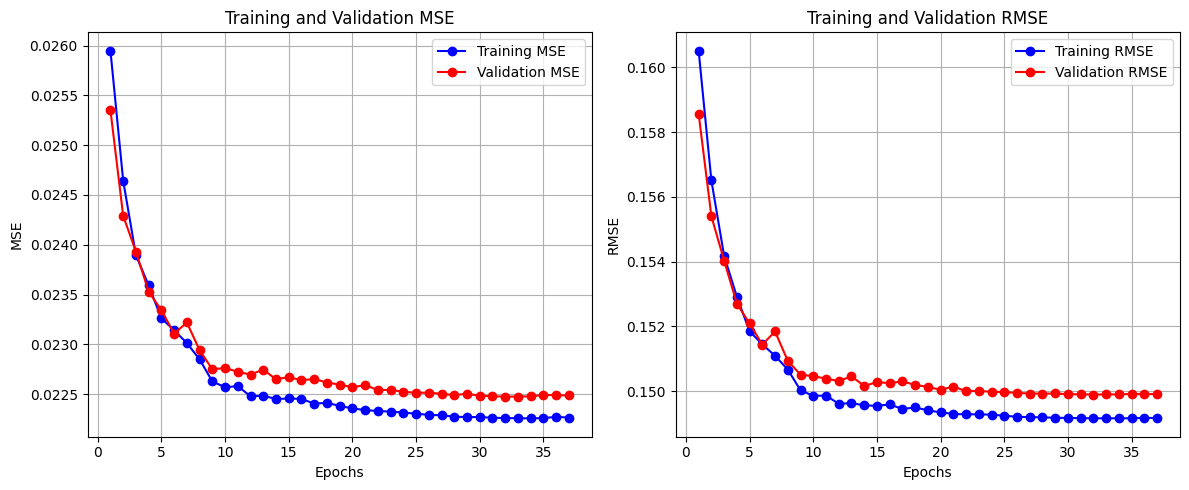

In [171]:
# Extracting loss and validation loss from the training history
mse = history.history['loss']
val_mse = history.history['val_loss']
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

# Plotting the MSE and RMSE
epochs = range(1, len(mse) + 1)

plt.figure(figsize=(12, 5))

# Plotting MSE
plt.subplot(1, 2, 1)
plt.plot(epochs, mse, 'bo-', label='Training MSE')
plt.plot(epochs, val_mse, 'ro-', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()

# Plotting RMSE
plt.subplot(1, 2, 2)
plt.plot(epochs, rmse, 'bo-', label='Training RMSE')
plt.plot(epochs, val_rmse, 'ro-', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 3.4. Save Neural Networks Model

In [ ]:
# Make assets directory
os.makedirs('./assets/model', exist_ok=True)

# Save model with saved_model
save_path = './assets/model'
saved_model.save(model, save_path)

# Convert jupyter notebook to python file

In [39]:
!jupyter nbconvert --to script 'model.ipynb'

[NbConvertApp] Converting notebook model.ipynb to script
[NbConvertApp] Writing 18557 bytes to model.py
